In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [77]:
class FakeBCM(object):

    def __init__(self, learning_rate=1e-9, in_neurons=4, theta_tau=1.0, sample_every=0.1, start_weights=None):
        self.kappa = learning_rate
        assert start_weights is not None
        self.omega = start_weights
        self.in_nrns = in_neurons
        self.theta = 0
        self.decay = np.exp(-0.001 / theta_tau)
        self.weight_history = []
        self.period = sample_every / 0.001

    def bcm_func(self, t, x):
        in_rates = x[:self.in_nrns]
        out_rates = x[self.in_nrns:]
        self.theta = out_rates * (1 - self.decay) + self.theta * self.decay
        self.omega += np.outer(self.kappa * out_rates * (out_rates - self.theta), in_rates)
        if (t / 0.001 % self.period) < 1:
            self.weight_history.append(self.omega)
        return np.dot(self.omega, in_rates)

In [71]:
pre_nrn = 4
post_nrn = 2

with nengo.Network() as tmp_model:
    pre = nengo.Ensemble(pre_nrn, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.1, 0, 0, -0.1],
                         max_rates=[250, 300, 300, 250])
    post = nengo.Ensemble(post_nrn, 1, encoders=[[1], [-1]], intercepts=[-0.05, -0.05], max_rates=[200, 200])
    conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True))

with nengo.Simulator(tmp_model) as tmp_sim:
    pass

weights = tmp_sim.data[conn].weights * post.radius / tmp_sim.data[post].gain[:, None]

A Jupyter Widget

In [95]:
with nengo.Network() as model:
    
    def stim_func(t):
        if (t % 0.5) * 2 > 0.5:
            return 0.3
        else:
            return -0.3
    
    sin = nengo.Node(stim_func)
    
    pre = nengo.Ensemble(pre_nrn, 1, encoders=[[1], [1], [-1], [-1]], intercepts=[-0.1, 0, 0, -0.1],
                         max_rates=[250, 300, 300, 250])
    post = nengo.Ensemble(post_nrn, 1, encoders=[[1], [-1]], intercepts=[-0.05, -0.05], max_rates=[200, 200])

    fake_bcm = FakeBCM(in_neurons=pre_nrn, start_weights=weights)
    learn = nengo.Node(fake_bcm.bcm_func, size_in=pre_nrn+post_nrn, size_out=post_nrn)

    nengo.Connection(sin, pre)

    nengo.Connection(pre.neurons, learn[:pre_nrn])
    nengo.Connection(post.neurons, learn[pre_nrn:])
    nengo.Connection(learn, post.neurons)

    p_nd = nengo.Probe(learn, synapse=0.01)
    p_in = nengo.Probe(pre, synapse=0.01)
    p_out = nengo.Probe(post, synapse=0.01)

In [96]:
with nengo.Simulator(model) as sim:
    sim.run(10)

A Jupyter Widget

A Jupyter Widget

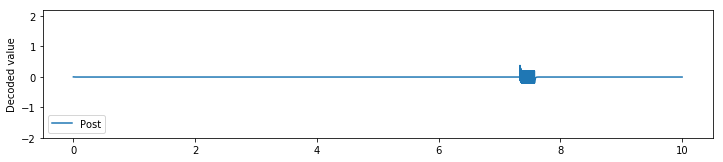

In [97]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_out], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-2, 2.2)
plt.legend(loc="lower left")

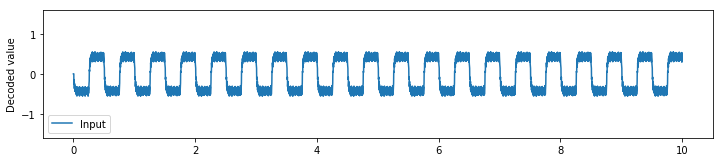

In [98]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_in], label="Input")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")

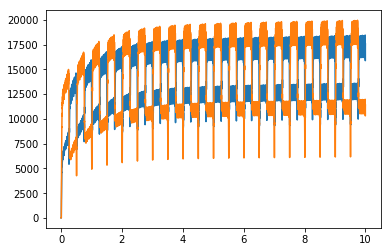

In [99]:
plt.plot(sim.trange(), sim.data[p_nd], label="Post")

In [90]:
w_hist = np.array(fake_bcm.weight_history)
print(w_hist.shape)

(101, 2, 4)


In [101]:
sim.trange(dt=0.1)[0]

0.10000000000000001

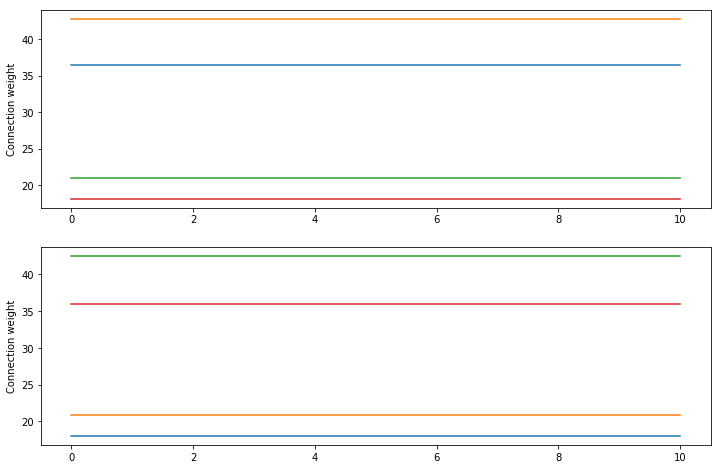

In [105]:
plt.figure(figsize=(12, 8))

w_hist_trange = np.concatenate(([0], sim.trange(dt=0.1),))

plt.subplot(2, 1, 1)
plt.plot(w_hist_trange, w_hist[:, 0])
plt.ylabel("Connection weight");
plt.subplot(2, 1, 2)
plt.plot(w_hist_trange, w_hist[:, -1])
plt.ylabel("Connection weight");